In [1]:
# !pip install shap
# %pip install catboost -U
# !pip install imblearn

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-и-обработка-данных" data-toc-modified-id="Анализ-и-обработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ и обработка данных</a></span><ul class="toc-item"><li><span><a href="#Модели-без-учета-дисбаланса" data-toc-modified-id="Модели-без-учета-дисбаланса-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модели без учета дисбаланса</a></span><ul class="toc-item"><li><span><a href="#catboost" data-toc-modified-id="catboost-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>catboost</a></span></li><li><span><a href="#SVC" data-toc-modified-id="SVC-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>SVC</a></span></li></ul></li><li><span><a href="#Модели-с-учетом-дисбаланса" data-toc-modified-id="Модели-с-учетом-дисбаланса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модели с учетом дисбаланса</a></span><ul class="toc-item"><li><span><a href="#Oversampling" data-toc-modified-id="Oversampling-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Oversampling</a></span><ul class="toc-item"><li><span><a href="#catboost" data-toc-modified-id="catboost-2.2.1.1"><span class="toc-item-num">2.2.1.1&nbsp;&nbsp;</span>catboost</a></span></li><li><span><a href="#SVC" data-toc-modified-id="SVC-2.2.1.2"><span class="toc-item-num">2.2.1.2&nbsp;&nbsp;</span>SVC</a></span></li></ul></li><li><span><a href="#class-weights" data-toc-modified-id="class-weights-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>class weights</a></span><ul class="toc-item"><li><span><a href="#catboost" data-toc-modified-id="catboost-2.2.2.1"><span class="toc-item-num">2.2.2.1&nbsp;&nbsp;</span>catboost</a></span></li><li><span><a href="#SVC" data-toc-modified-id="SVC-2.2.2.2"><span class="toc-item-num">2.2.2.2&nbsp;&nbsp;</span>SVC</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Интерпретация-результатов" data-toc-modified-id="Интерпретация-результатов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Интерпретация результатов</a></span></li><li><span><a href="#ROC" data-toc-modified-id="ROC-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ROC</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо:
1. Исследовать баланс классов, обучив 2 модели без учёта дисбаланса.
2. Улучшить качество моделей, обработав дисбаланс классов 2 способами
1. Построить модель позволяющую спрогнозировать, уйдёт клиент из банка в ближайшее время или нет, которая имела бы значением *F1*-меры более 0.59.
3. Измерить  *AUC-ROC*.


In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import shap

from catboost import CatBoostClassifier, cv
from catboost.utils import get_roc_curve
from catboost.core import Pool

from sklearn.svm import SVC

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, auc

## Подготовка данных

Посмотрим на предоставленные данные

In [3]:
df = pd.read_csv("/datasets/Churn.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Согласно приложенной документации, в колонках содержется следующая информация:

<b>Признаки</b>  
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — сколько лет человек является клиентом банка  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата 

<b>Целевой признак</b>  
Exited — факт ухода клиента

In [4]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

В 9% записей имеются пропуски в данных о стаже клиента.
Так как нет средств позволяющих с высокой точностью их востановить, а данный признак может быть связанным с целевым, оставшееся количество записей позволяет удалить клиентов с пропусками из дальнейшего анализа.

In [5]:
df = df.dropna()

Приведем названия колонок в соответствие с хорошим стилем

In [6]:
def lowering(word):
  for symbol in set(word):
    if not symbol.islower():
      word = word.replace(symbol, '_'+symbol)
  return word[1:].lower()

In [7]:
df.columns = [lowering(name) for name in df.columns]

Фичи `row_number`, `customer_id`, `surname` являются системными данными не нужными для предсказания

In [8]:
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

Излишняя точность показателей `balance`, `estimated_salary` и `tenure` только усложнит расчеты

In [9]:
df.balance = df.balance.astype(int)
df.estimated_salary = df.estimated_salary.astype(int)
df.tenure = df.tenure.astype(int)

Для наглядности в последующей интепретации результатов оцифруем качественные признаки

In [10]:
df = pd.get_dummies(df).drop(['geography_Spain','gender_Female'], axis=1)
df

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_France,geography_Germany,gender_Male
0,619,42,2,0,1,1,1,101348,1,1,0,0
1,608,41,1,83807,1,0,1,112542,0,0,0,0
2,502,42,8,159660,3,1,0,113931,1,1,0,0
3,699,39,1,0,2,0,0,93826,0,1,0,0
4,850,43,2,125510,1,1,1,79084,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2,0,2,0,0,167773,0,1,0,0
9995,771,39,5,0,2,1,0,96270,0,1,0,1
9996,516,35,10,57369,1,1,1,101699,0,1,0,1
9997,709,36,7,0,1,0,1,42085,1,1,0,0


## Анализ и обработка данных

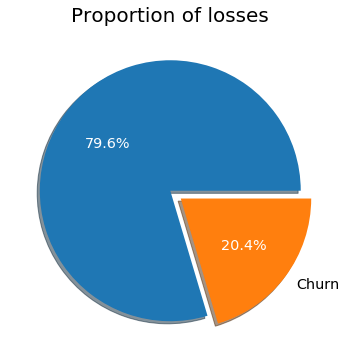

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

patches, texts, pcts = ax.pie(df.exited.value_counts(),
        autopct='%.1f%%',
        textprops= {'size': 'x-large'},
        explode= [0,0.1],
        labels = ['', 'Churn'],
        shadow = True);
plt.setp(pcts, color='white');
plt.title('Proportion of losses', fontsize=20);

В предоставленных данных, за рассматриваемый период, около 20% клиентов решили прекратить пользоваться услугами «Бета-Банка».

Посмотрим как этот дисбаланс скажется на обучении моделей

### Модели без учета дисбаланса

По плану заказчика сначала обучим модели без учета дисбаланса классов.

Разделим данные на тренировочные и тестовые.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('exited', axis=1),
                                                    df.exited,
                                                    test_size=0.33,
                                                    random_state=42)

#### catboost

In [13]:
parametrs = {'depth': range(5,10)}

cbc = GridSearchCV(CatBoostClassifier(iterations=2000,
                                      loss_function='Logloss',
                                      custom_loss='F1',
                                      eval_metric='F1',
                                      early_stopping_rounds=200,
                                      learning_rate=0.01,
                                     ),
                   parametrs,
                   scoring='f1',
                   cv=5)

cbc.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)

print(f'Значением F1-меры для модели обученной без учета дисбаланса классов: \
      {f1_score(y_test, cbc.predict(X_test)):.3f}')

Значением F1-меры для модели обученной без учета дисбаланса классов:       0.575


#### SVC

In [14]:
ppline_svc = make_pipeline(preprocessing.StandardScaler(),
                           SVC())

parametrs = {'svc__kernel':['poly','rbf']}
             
svc = GridSearchCV(ppline_svc, parametrs, scoring='f1', cv=5)
                     
svc.fit(X_train, y_train)

print(f'Значением F1-меры для модели обученной без учета дисбаланса классов: \
      {f1_score(y_test, svc.predict(X_test)):.3f}')

Значением F1-меры для модели обученной без учета дисбаланса классов:       0.489


Полученные значение F1 не достигают необходимой величины 0.59  
Поэтому воспользуемся методиками для борьбы с дисбалансом классов

### Модели с учетом дисбаланса

#### Oversampling

##### catboost

In [15]:
parametrs = {'catboostclassifier__depth': range(5,10)}

cbc = CatBoostClassifier(iterations=2000,
                         loss_function='Logloss',
                         custom_loss='F1',
                         eval_metric='F1',
                         early_stopping_rounds=200,
                         learning_rate=0.01,
                        )

pipe_cbc = make_pipeline(RandomOverSampler(), cbc)

gcbc_over = GridSearchCV(pipe_cbc,
                   parametrs,
                   scoring='f1',
                   cv=5)

gcbc_over.fit(X_train, y_train, catboostclassifier__verbose=0)

print(f'Значением F1-меры для модели обученной c оверсемплингом классов: \
      {f1_score(y_test, gcbc_over.predict(X_test)):.3f}')

Значением F1-меры для модели обученной c оверсемплингом классов:       0.607


##### SVC

In [16]:
ppline_svc = make_pipeline(RandomOverSampler(),
                           preprocessing.StandardScaler(),
                           SVC())
parametrs = {'svc__kernel':['poly','rbf']}
             
svc_over = GridSearchCV(ppline_svc, parametrs, scoring='f1', cv=5)
                     
svc_over.fit(X_train, y_train)

print(f'Значением F1-меры для модели обученной с оверсемплингом классов: \
      {f1_score(y_test, svc_over.predict(X_test)):.3f}')

Значением F1-меры для модели обученной с оверсемплингом классов:       0.587


#### class weights

##### catboost

In [17]:
parametrs = {'depth': range(5,10)}

cbc = CatBoostClassifier(iterations=2000,
                         loss_function='Logloss',
                         custom_loss='F1',
                         eval_metric='F1',
                         early_stopping_rounds=200,
                         learning_rate=0.01,
                         auto_class_weights='Balanced' # веса клоссов сбалансированны
                        )

gcbc_bal = GridSearchCV(cbc,
                   parametrs,
                   scoring='f1',
                   cv=5)

gcbc_bal.fit(X_train, y_train, verbose=0)

print(f'Значением F1-меры для модели обученной cо сбалансированными весами классов: \
      {f1_score(y_test, gcbc_bal.predict(X_test)):.3f}')

Значением F1-меры для модели обученной cо сбалансированными весами классов:       0.611


##### SVC

In [18]:
ppline_svc = make_pipeline(preprocessing.StandardScaler(),
                           SVC(class_weight='balanced')) # веса клоссов сбалансированны
parametrs = {'svc__kernel':['poly','rbf']}
             
svc = GridSearchCV(ppline_svc, parametrs, scoring='f1', cv=5)
                     
svc.fit(X_train, y_train)

print(f'Значением F1-меры для модели обученной cо сбалансированными весами классов: \
      {f1_score(y_test, svc.predict(X_test)):.3f}')

Значением F1-меры для модели обученной cо сбалансированными весами классов:       0.586


Модель catboost с предобработкой дисбаланса классов позволила достигнуть необходимого значения F1

Продолжим работать с наилучшей моделью

In [21]:
best_model = gcbc_bal.best_estimator_

## Интерпретация результатов

Визуализируем важность признаков при прогнозировании обученной модели

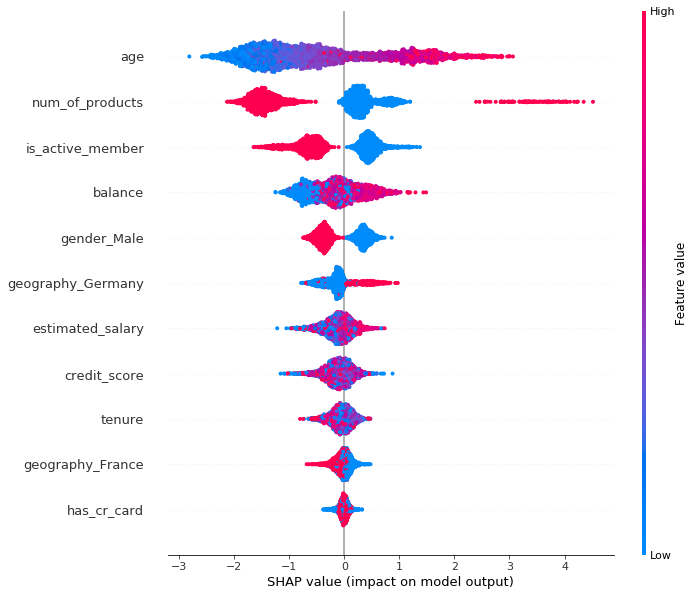

In [22]:
shap.summary_plot(shap.TreeExplainer(best_model).shap_values(Pool(X_test,
                                                                  y_test,
                                                                 )),
                  X_test,
                  plot_size=(10,10))

<b>Стаж, кредитный рейтинг, предполагаемая зарплата и наличие кредитной карты</b> - показатели не являющиеся основополагающими при принятии решения покинуть ряды клиентов «Бета-Банка»

<b>Geography</b> - Немецкие филиалы хуже справляются с местным менталитетом, из-за чего доля уходов в Германии немного выше, а вот Французы немного более лояльны.

<b>Balance</b> - видна небольшая зависимость, что присутсвует клиенты с большими деньгами не удовлетворенные услугами  «Бета-Банка»

<b>Gender, Active</b> - женщины покидают «Бета-Банк» чаще мужчин, а признак неактивности клиента является знаком к возможному уходу

<b>Age</b> - один из важнейших признаков. Нет данных связан ли уход из «Бета-Банка» со смертью клиента, но великовозрастные клиенты с возрастом покидают банк все чаще.

В данном виде  признак <b>num_of_product</b> не однозначен. Рассмотрим его отдельно

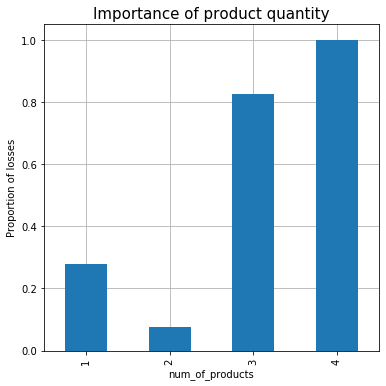

In [23]:
plt.figure(figsize=(6,6))
df.groupby('num_of_products').exited.mean().plot(kind='bar', grid=True, zorder=2);
plt.ylabel('Proportion of losses');
plt.title('Importance of product quantity', fontsize=15);

Клиенты с 2 продуктами уходят из «Бета-Банка» в среднем гораздо реже, в вот использующие 3 или 4 продукта, согласно данным, практически точно в скором времени покинут «Бета-Банка».

## ROC

AUC-ROC обученной модели

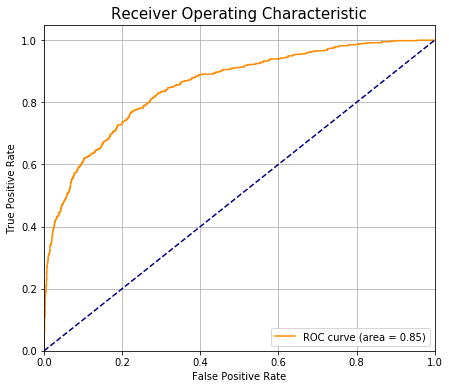

In [24]:
(fpr, tpr, trh) = get_roc_curve(best_model, Pool(X_test, y_test))

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)'% auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.legend(loc='lower right')
plt.grid()

## Выводы

1. Обучены модели в запрашиваемом виде с необходимыми метриками
2. Наблюдается высокая неудовлетворенность возрастных, богатых клиентов пользующимися несколькими продуктами «Бета-Банка»